In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython

In [3]:
# Import CSV to Pandas
# link = "https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-hourly&stations=72495723213&dataTypes=DATE,REPORT_TYPE,WND&startDate=2000-01-01&endDate="
# endDate = "2023-12-12"
# link += endDate
link ="./global-hourly-2023-12-29T11-33-21.csv"
data = pd.read_csv(link,usecols=["WND","REPORT_TYPE","DATE"],dtype={"WND": str, "REPORT_TYPE": str, "DATE": str})

In [4]:
# Remove SOD and SOM reports 
data = data[~data['REPORT_TYPE'].isin(['SOD  ','SOM  '])]

In [5]:
# Split the wind data into seperate collumns
split_values = data['WND'].str.split(',', expand=True)
num_columns = len(split_values.columns)
split_values.columns = ["Direction","Direction_Quality","Type","Speed","Speed_Quality"]
data = pd.concat([data, split_values], axis=1)

In [6]:
# Drop redundant collumns
data.drop(["REPORT_TYPE","WND"],axis=1,inplace=True)

In [7]:
# Convert Speed and Direction collumns to ints
data['Direction'] = data['Direction'].astype(int)
data['Speed'] = data['Speed'].astype(int)

In [8]:
# Standardize calm and variable wind
data.loc[data['Type'] == 'C', 'Speed'] = 0
data.loc[data['Type'] == 'C', 'Direction'] = 0

In [9]:
# Remove data flagged as erroneous
data = data[data['Type'].isin(["N","C"])]
data = data[data['Direction_Quality'].isin(['0', '1', '4', '5', '9'])]# Direction quality
data = data[data['Speed_Quality'].isin(['0', '1', '4', '5', '9'])]# Speed quality

In [10]:
# Remove impossibile measurements
data = data[(data['Direction'].between(0, 360))]

In [11]:
# Remove validation collumns
data.drop(["Direction_Quality","Type","Speed_Quality"],axis=1,inplace=True)

In [12]:
#Convert Wind to Vector
windRadians = data["Direction"]*np.pi/180
data['Wx'] = data['Speed']*np.cos(windRadians)
data['Wy'] = data['Speed']*np.sin(windRadians)
print(data)

                       DATE  Direction  Speed         Wx         Wy
0       2000-01-01T00:53:00        280     21   3.646612 -20.680963
1       2000-01-01T01:53:00        130     36 -23.140354  27.577600
2       2000-01-01T02:53:00          0      0   0.000000   0.000000
3       2000-01-01T03:53:00         10     26  25.605002   4.514853
4       2000-01-01T04:08:00         40     31  23.747378  19.926416
...                     ...        ...    ...        ...        ...
295560  2023-12-12T21:53:00        160     15 -14.095389   5.130302
295561  2023-12-12T22:00:00        190     21 -20.680963  -3.646612
295562  2023-12-12T22:25:00        140     15 -11.490667   9.641814
295563  2023-12-12T22:53:00        140     21 -16.086933  13.498540
295564  2023-12-12T23:53:00        170     15 -14.772116   2.604723

[272336 rows x 5 columns]


In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Direction,272336.0,121.557047,118.265665,0.000000,0.000000,140.0,200.000000,360.000000
Speed,272336.0,18.560165,19.831400,0.000000,0.000000,15.0,31.000000,160.000000
Wx,272336.0,-6.356313,21.497614,-150.350819,-19.733545,0.0,0.000000,140.014200
Wy,272336.0,-0.957991,15.306775,-122.116161,-4.514853,0.0,3.646612,101.435199


(-150.35081932574533,
 140.01420049710035,
 -122.1161613735138,
 101.43519856025743)

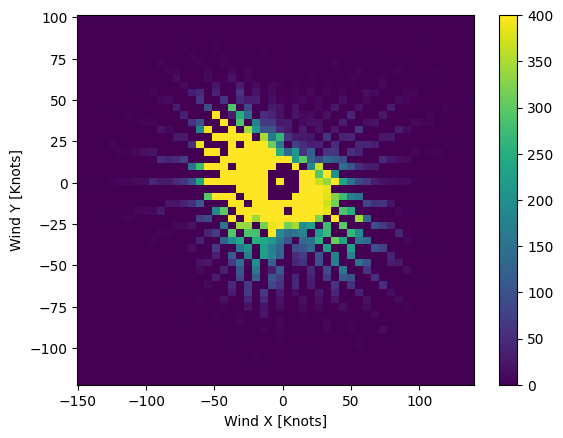

In [14]:
from matplotlib import pyplot as plt


plt.hist2d(data['Wx'], data['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [Knots]')
plt.ylabel('Wind Y [Knots]')
ax = plt.gca()
ax.axis('tight')

In [15]:
# date_time = pd.to_datetime(data.pop('DATE'), format='%d.%m.%Y %H:%M:%S')
# column_indices = {name: i for i, name in enumerate(data.columns)}
# print(column_indices)
timestamp_s = pd.to_datetime(data['DATE']).map(pd.Timestamp.timestamp)
data['DATE'] = timestamp_s
print(timestamp_s)

0         9.466880e+08
1         9.466916e+08
2         9.466952e+08
3         9.466988e+08
4         9.466997e+08
              ...     
295560    1.702418e+09
295561    1.702418e+09
295562    1.702420e+09
295563    1.702422e+09
295564    1.702425e+09
Name: DATE, Length: 272336, dtype: float64


In [16]:
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [17]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]
print(train_data)

                DATE  Direction  Speed         Wx         Wy   Day sin  \
0       9.466880e+08        280     21   3.646612 -20.680963  0.229200   
1       9.466916e+08        130     36 -23.140354  27.577600  0.473320   
2       9.466952e+08          0      0   0.000000   0.000000  0.685183   
3       9.466988e+08         10     26  25.605002   4.514853  0.850352   
4       9.466997e+08         40     31  23.747378  19.926416  0.882948   
...              ...        ...    ...        ...        ...       ...   
206970  1.480809e+09        200     15 -14.095389  -5.130302 -0.030539   
206971  1.480813e+09        150     21 -18.186533  10.500000  0.229200   
206972  1.480816e+09          0      0   0.000000   0.000000  0.473320   
206973  1.480820e+09          0      0   0.000000   0.000000  0.685183   
206974  1.480824e+09        280     15   2.604723 -14.772116  0.850352   

         Day cos  Year sin  Year cos  
0       0.973379 -0.004098  0.999992  
1       0.880891 -0.003381  0.999

In [18]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

C:\Users\Lande\AppData\Local\Temp\ipykernel_47480\3449341323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(data.keys(), rotation=90)


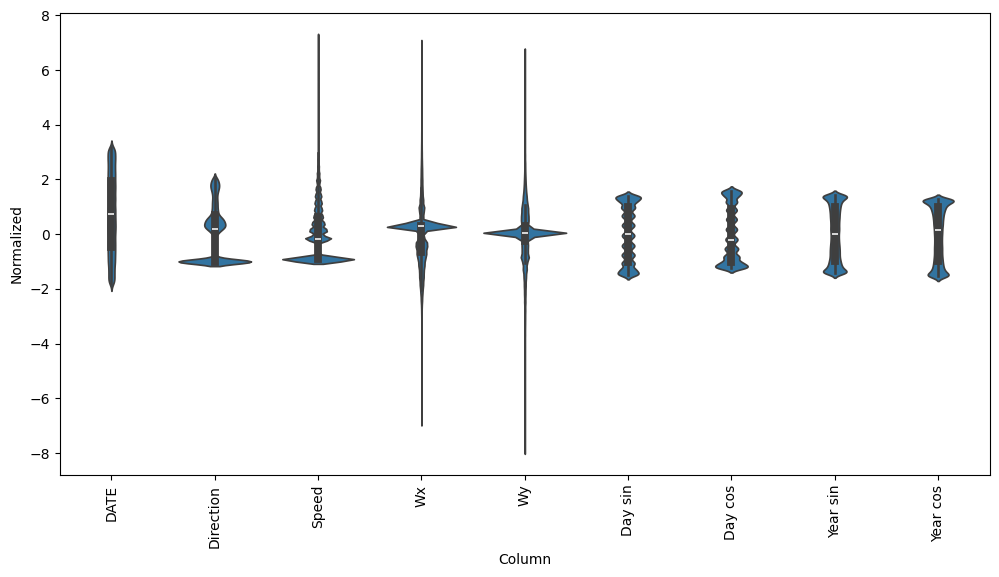

In [19]:
import seaborn as sns

data_std = (data - train_mean) / train_std
data_std = data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_data=train_data, val_data=val_data, test_data=test_data,
               label_columns=None):
    # Store the raw data.
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Wx'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Wx']

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_data[:w2.total_window_size]),
                           np.array(train_data[100:100+w2.total_window_size]),
                           np.array(train_data[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='Wx', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

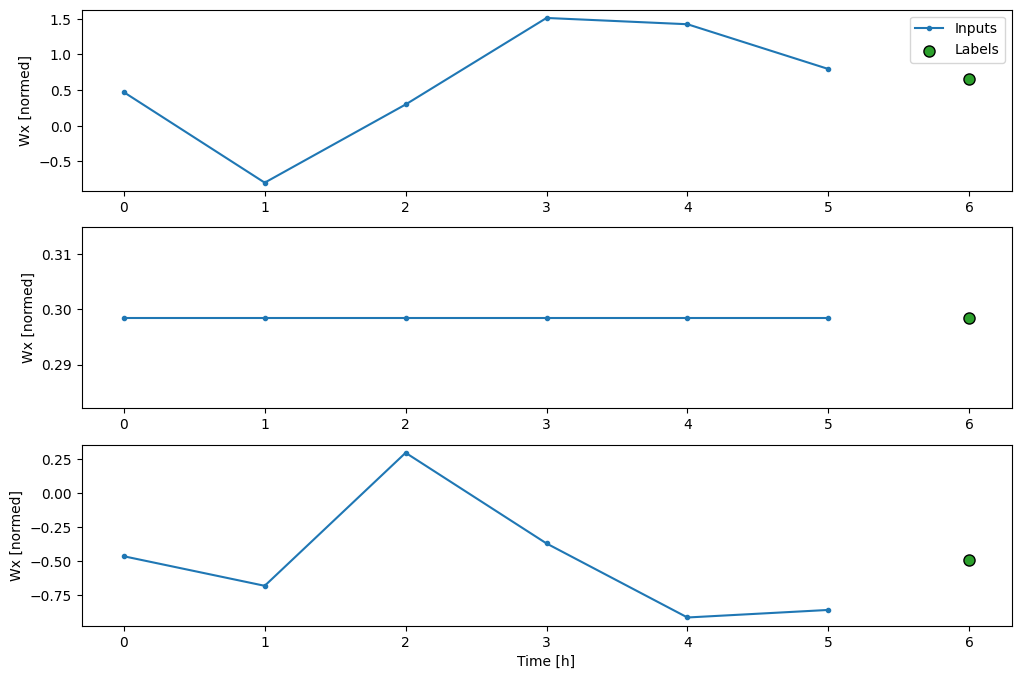

In [26]:
w2.plot()

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_data)

@property
def val(self):
  return self.make_dataset(self.val_data)

@property
def test(self):
  return self.make_dataset(self.test_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Wx'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Wx']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [34]:
baseline = Baseline(label_index=column_indices['Wx'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)




1703/1703 [==============================] - 6s 3ms/step - loss: 0.3540 - mean_absolute_error: 0.3733


In [35]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Wx'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Wx']

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


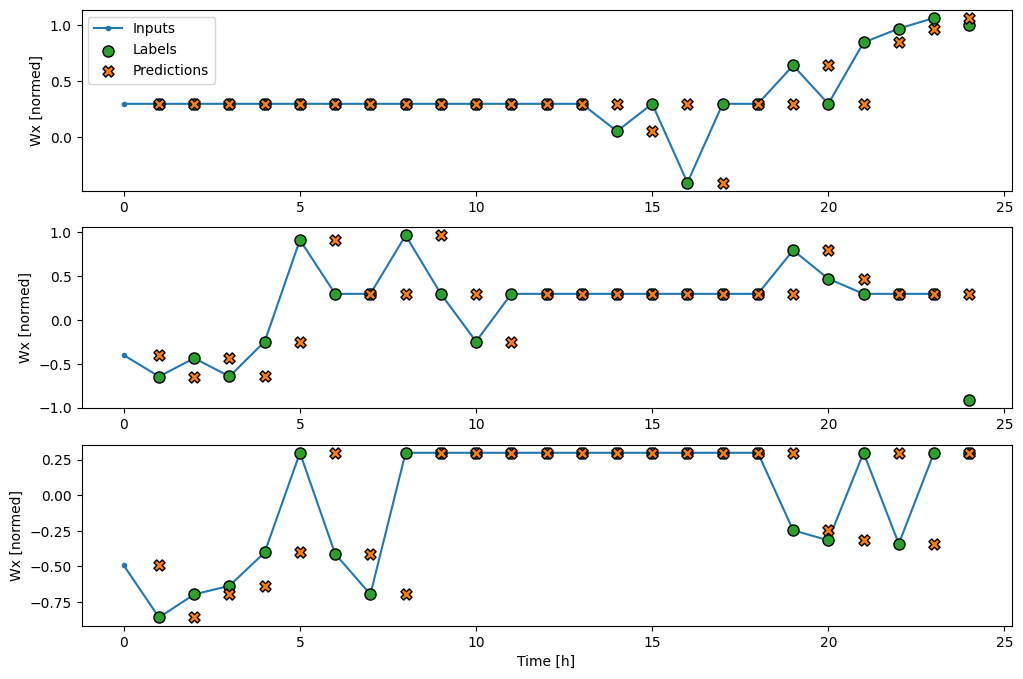

In [37]:
wide_window.plot(baseline)

In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [43]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1702/1702 [==============================] - 21s 12ms/step - loss: 0.2825 - mean_absolute_error: 0.3563


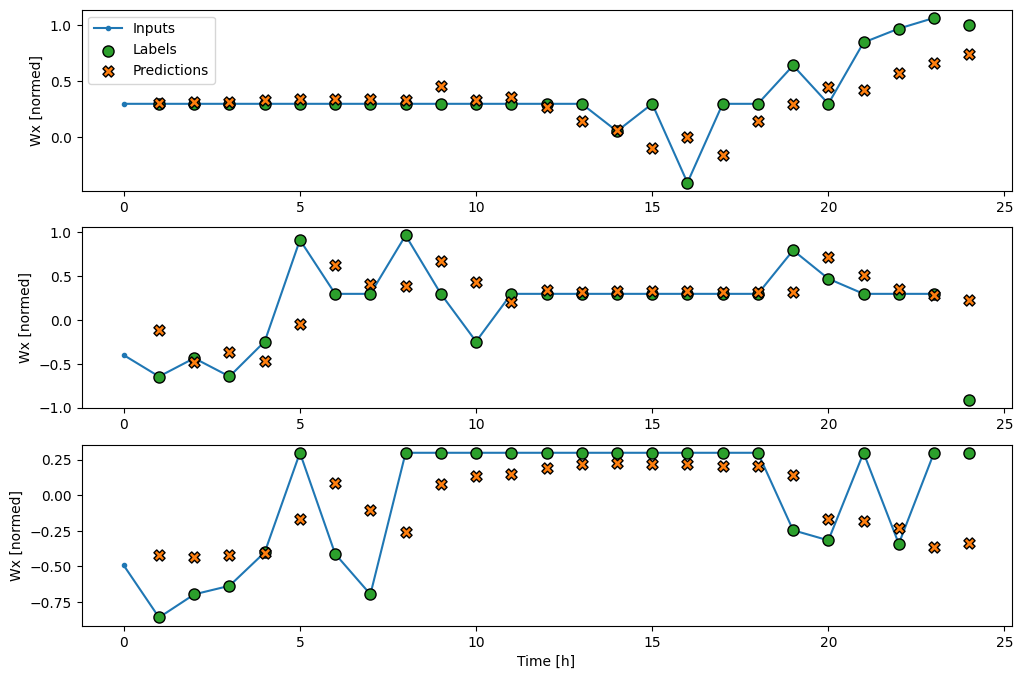

In [44]:
wide_window.plot(lstm_model)

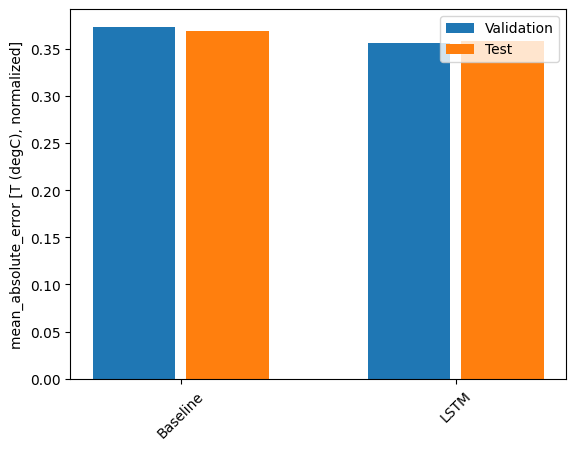

In [45]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
# data.to_csv("output2.csv",index=False)